Feature Engineering specific steps
1. Normalizing the features
2. More intentional data imputation
3. Creating aggregate features + dropping irrelevant ones

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv', index_col = [0])
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# step 1: data exploration

In [3]:
numerical_data = df.select_dtypes(include=['int64','float64']).drop('SalePrice', axis=1)
# numerical_data.describe()
# note that MSSubClass is supposed to be a category but its written as a num here, change later

In [4]:
categorical_data = df.select_dtypes(include='object')
# categorical_data.describe()

### numerical data


#### observations
- noticing some linear relationships in like 2ndFlrSF, GarageArea
- GrLivArea, TotalBsmtSF, 1stFlrSF also have stronger regression lines BUT the residuals wouldn't be even so not a proper linear relationship
    - basically the size related ones of pretty "common sense" major areas of the house
- there seems to be an outlier with a very low sale price but high SF in a few graphs, not sure if its the same point or different ones though
- open porch and 1st floor SF just look like they are fanning out for now but could potentially mean interations with other values creating like one line with a steeper slope and another with a flatter one? just a thought to explore
    
**reminder to not forget that many of these hold a lot of 0 values worth reincoporating/investigating/dealing with separately later**

### observations
- MSSubClass, OverallCond, OverallQual are more-so ordinal categorical data hidden as numerical values
- many of the other low std values are simply discrete counts like number of bathrooms, rooms, kitchens etc.
- very few pool data points as we saw when checking nulls, could be better to remove/make binary again
- month and year are very un-promising for now, can't think of any reason why it would matter later yet either for now
- overall quality + total rooms above ground seem to have more of a correlation with price which also checks out logically
- random note: later when dealing with the model, check the normality of these quantative variables too

# imputing

In [5]:
from sklearn.model_selection import train_test_split

# i don't think the data has any null Prices but for future reference
# it is good to remove rows with missing targets
df.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = df.SalePrice
X = df.drop('SalePrice', axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor

# separate numerical and categorical transformers
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
#     ('imputer', SimpleImputer(strategy='constant')), 
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('imputer', SimpleImputer(strategy='constant', fill_value="Missing")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    # can try target encoding too from Feature Engineering course
])

numerical_cols = numerical_data.columns
categorical_cols = categorical_data.columns

# combining transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
])

In [7]:
model_temp = XGBRegressor(n_estimators = 500, max_depth = 3, learning_rate = 0.1)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', model_temp)])
# pipeline.fit(X_train, y_train)

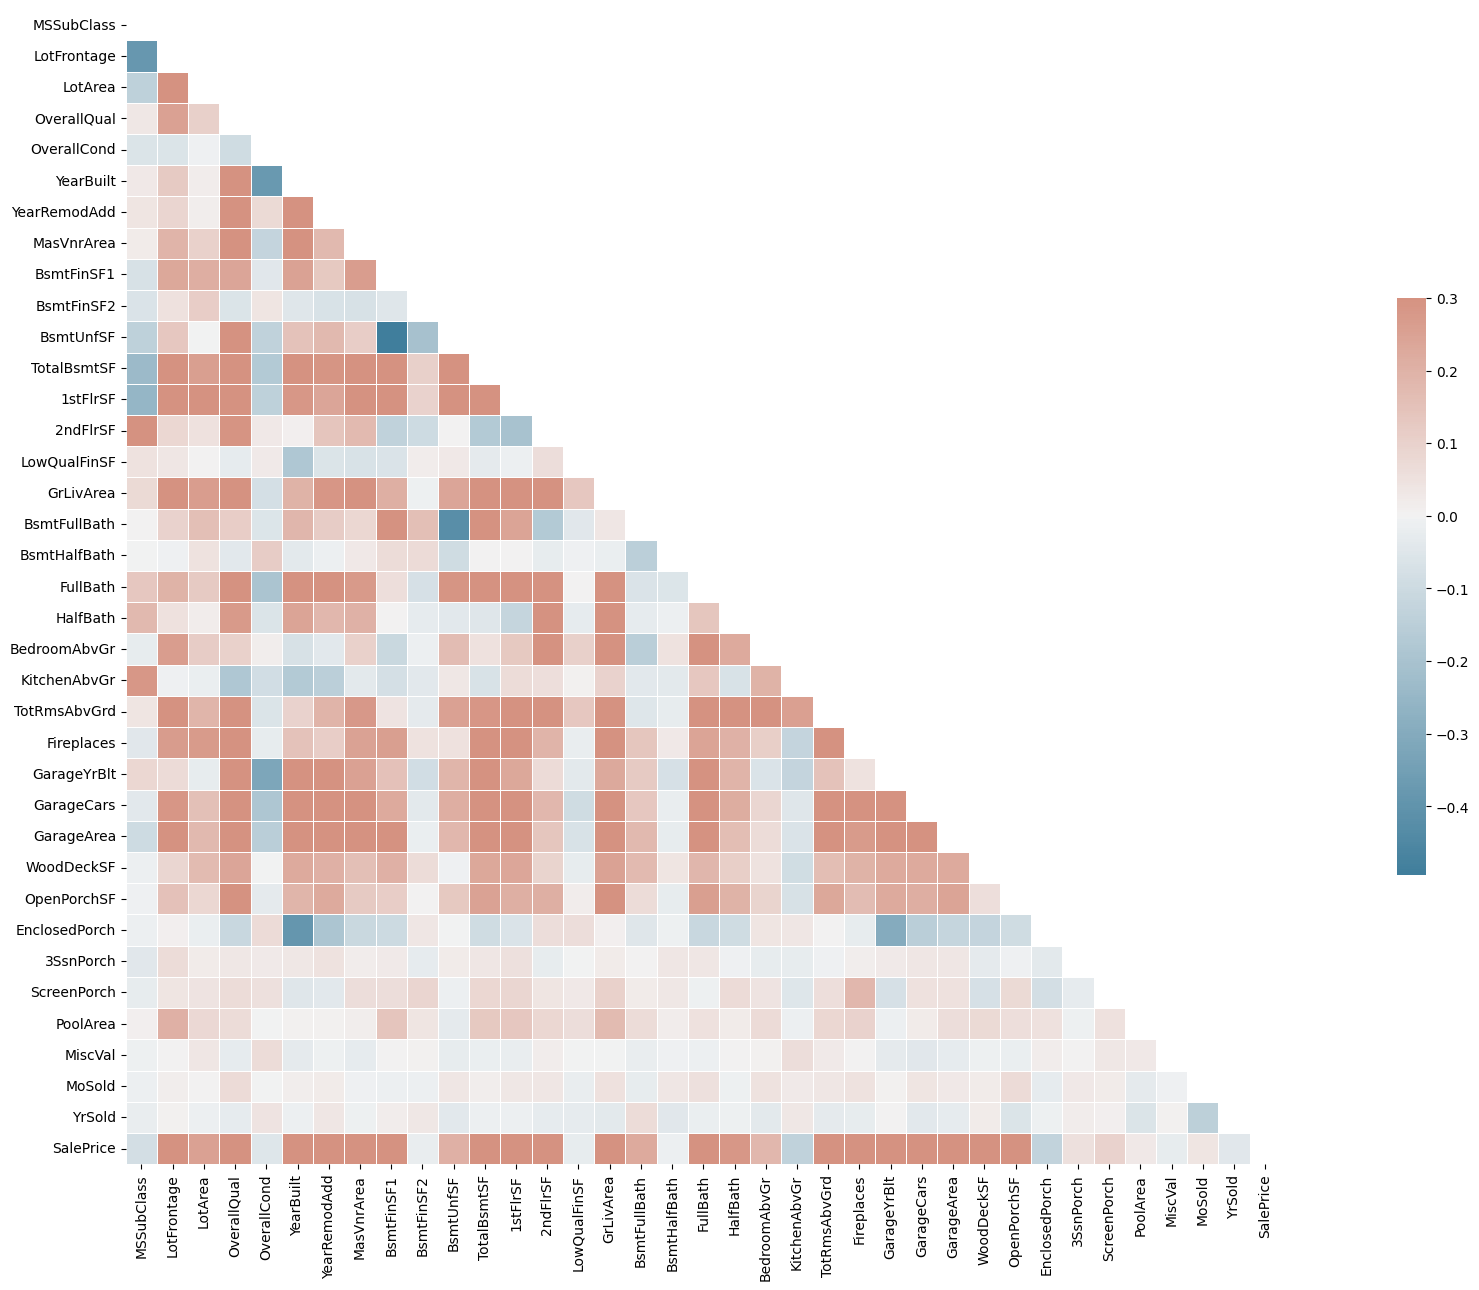

In [8]:
# Calculate the correlation matrix
numerical_data['SalePrice'] = y_train
corr = numerical_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(30, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

### dropping low MI features leads to ___ results

In [9]:
low_mi_cols = ["MoSold", "MiscVal", "PoolArea", "LowQualFinSF", "BsmtHalfBath", "BsmtFinSF2", "YrSold", "KitchenAbvGr", "3SsnPorch"]
## ^^ found from other notebook

def drop_cols(cols, df):
    new_df = df.copy()
    new_df = new_df.drop(cols, axis=1)
    return new_df

# feature engineering

In [10]:
def fix_categorical(df):
    df = df.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                 "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                 "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                 "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4,
                                         "ALQ" : 5, "GLQ" : 6},
                 "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4,
                                         "ALQ" : 5, "GLQ" : 6},
                 "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                 "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5,
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )
    return df

In [11]:
def add_new_features(df):
    df_copy = df.copy()
    
    df_copy['TotalArea'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df_copy['TotalBathrooms'] = df['FullBath'] + 0.5*df['HalfBath'] + df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']
    df_copy['AgeAtSale'] = df['YrSold'] - df['YearBuilt']
    df_copy['YearsSinceRemodel'] = df['YrSold'] - df['YearRemodAdd']
    df_copy['TotalQual'] = df['OverallQual'] + df['ExterQual'] + df['KitchenQual'] + df['BsmtQual'] + df['GarageQual']
    df_copy['TotalCond'] = df['OverallCond'] + df['ExterCond'] + df['BsmtCond'] + df['GarageCond']
    df_copy['OutdoorSpace'] = df[['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']].sum(axis=1)
    df_copy['HasPool'] = (df['PoolArea'] > 0).astype(int)
    df_copy['HasGarage'] = (df['GarageArea'] > 0).astype(int)
    df_copy['HasAlley'] = (df['Alley'] > 0).astype(int)
    df_copy['LotFrontageAreaRatio'] = df['LotFrontage'] / df['LotArea']
    
    return df_copy

# remove_these_cols = ['PoolArea', 'GarageArea', 'Alley']

In [12]:
def modify_features(df):
    return drop_cols(low_mi_cols, add_new_features(fix_categorical(df)))

new_X_train = modify_features(X_train)
# new_X_train.head()
new_X_valid = modify_features(X_valid)
# new_X_valid

# submissions

In [13]:
X_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')
new_X_test = modify_features(X_test)
new_X_test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,TotalBathrooms,AgeAtSale,YearsSinceRemodel,TotalQual,TotalCond,OutdoorSpace,HasPool,HasGarage,HasAlley,LotFrontageAreaRatio
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,2,NaN,4,Lvl,4.0,Inside,...,1.0,49,49,17.0,15.0,260,0,1,0,0.006883
1462,20,RL,81.0,14267,2,NaN,3,Lvl,4.0,Corner,...,1.5,52,52,19.0,15.0,429,0,1,0,0.005677
1463,60,RL,74.0,13830,2,NaN,3,Lvl,4.0,Inside,...,2.5,13,12,18.0,14.0,246,0,1,0,0.005351
1464,60,RL,78.0,9978,2,NaN,3,Lvl,4.0,Inside,...,2.5,12,12,19.0,15.0,396,0,1,0,0.007817
1465,120,RL,43.0,5005,2,NaN,3,HLS,4.0,Inside,...,2.0,18,18,23.0,14.0,226,0,1,0,0.008591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,2,NaN,4,Lvl,4.0,Inside,...,1.5,36,36,NaN,NaN,0,0,0,0,0.010847
2916,160,RM,21.0,1894,2,NaN,4,Lvl,4.0,Inside,...,1.5,36,36,16.0,14.0,24,0,1,0,0.011088
2917,20,RL,160.0,20000,2,NaN,4,Lvl,4.0,Inside,...,2.0,46,10,17.0,16.0,474,0,1,0,0.008000


#### simple RandomForestRegressor 

#### best model before feature engineering

In [14]:
#### evaluate the mode;

In [15]:
X_new = modify_features(X)

In [16]:
numerical_data = X_new.select_dtypes(include=['int64','float64'])
categorical_data = X_new.select_dtypes(include='object')
# separate numerical and categorical transformers
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_cols = numerical_data.columns
categorical_cols = categorical_data.columns

# combining transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
])

model_temp = XGBRegressor(n_estimators = 500, max_depth = 3, learning_rate = 0.1)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('model', model_temp)])
# pipeline.fit(X_train, y_train)

In [17]:
pipeline.fit(X_new, y)
predictions = pipeline.predict(new_X_test)

output = pd.DataFrame({'Id': new_X_test.index,
                       'SalePrice': predictions})
output.to_csv('submission.csv', index=False)

# improvements to make
- intentional imputation (e.g. reading through data labels better to identify NA values)
- standardize the features for better analysis and to do PCA